<a href="https://colab.research.google.com/github/livio-24/TwitterSentimentAnalysis/blob/main/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Upload your kaggle.json file

In [2]:
#configuring the path of Kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Importing twitter sentiment dataset from kaggle through API

In [3]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
#extracting compressed dataset
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset, 'r') as zips:
  zips.extractall()
  print('dataset extracted')

dataset extracted


Importing dependencies

In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Exploring dataset

In [8]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = DATASET_COLUMNS, encoding = 'ISO-8859-1')

In [9]:
twitter_data.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
twitter_data.shape

(1600000, 6)

In [11]:
twitter_data['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

<ipython-input-12-56c8098dd3e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twitter_data['sentiment'] = twitter_data['sentiment'].replace(4,1)


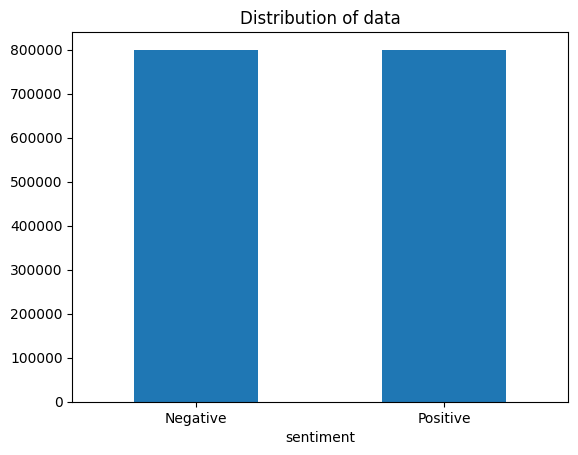

In [12]:
# Removing the unnecessary columns.
twitter_data = twitter_data[['sentiment','text']]
# Replacing the values to ease understanding.
twitter_data['sentiment'] = twitter_data['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = twitter_data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(twitter_data['text']), list(twitter_data['sentiment'])

0 = negative
1 = positive

The dataset is balanced

In [13]:
twitter_data.isnull().sum()

sentiment    0
text         0
dtype: int64

No missing values

Text pre-processing

In [14]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [15]:
# Abbreviations and/or slangs
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [16]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

In [17]:
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens=[convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [18]:
'''
def lemmatize_words_in_text(text):
    wnl = WordNetLemmatizer()
    tokens = word_tokenize(text)
    words = []
    for word, tag in pos_tag(tokens):
      print(word, tag[0])
      wntag = tag[0].lower()
      wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
    # Checking if the word is a stopword. if word not in stopwordlist:
      if not word in stopwords.words('english'):
        lemma = wnl.lemmatize(word, wntag) if wntag else word
        words.append(lemma)

    text = ' '.join(words)
    return text
    '''

"\ndef lemmatize_words_in_text(text):\n    wnl = WordNetLemmatizer()\n    tokens = word_tokenize(text)\n    words = []\n    for word, tag in pos_tag(tokens):\n      print(word, tag[0])\n      wntag = tag[0].lower()\n      wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None\n    # Checking if the word is a stopword. if word not in stopwordlist:\n      if not word in stopwords.words('english'):\n        lemma = wnl.lemmatize(word, wntag) if wntag else word\n        words.append(lemma)\n\n    text = ' '.join(words)\n    return text\n    "

In [19]:
def stemming(text):
    port_stem = PorterStemmer()
    tokens = word_tokenize(text)
    # Checking if the word is a stopword. if word not in stopwordlist:
    tokens=[port_stem.stem(word) for word in tokens if not word in stopwords.words('english')]
    text = ' '.join(tokens)
    return text

In [20]:
stemming('upset update facebook texting might cry result school today also blah')

'upset updat facebook text might cri result school today also blah'

In [21]:
def preprocess(textdata):
    processedText = []

    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        # Replace abbreviations/slangs
        tweet = convert_abbrev_in_text(tweet)
        # stemming words, removing stopwords
        tweet = stemming(tweet)
        '''
        tweetwords = ''
        #todo, pos tagging before lemmatize
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if not word in stopwords.words('english'):
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
        '''
        processedText.append(tweet)

    return processedText

In [22]:
import time
t = time.time()
#processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0 seconds


Word Cloud negative tweets

In [23]:
#I saved processed text on drive
processedtext = list(np.load('/content/drive/MyDrive/processedtext.npy'))

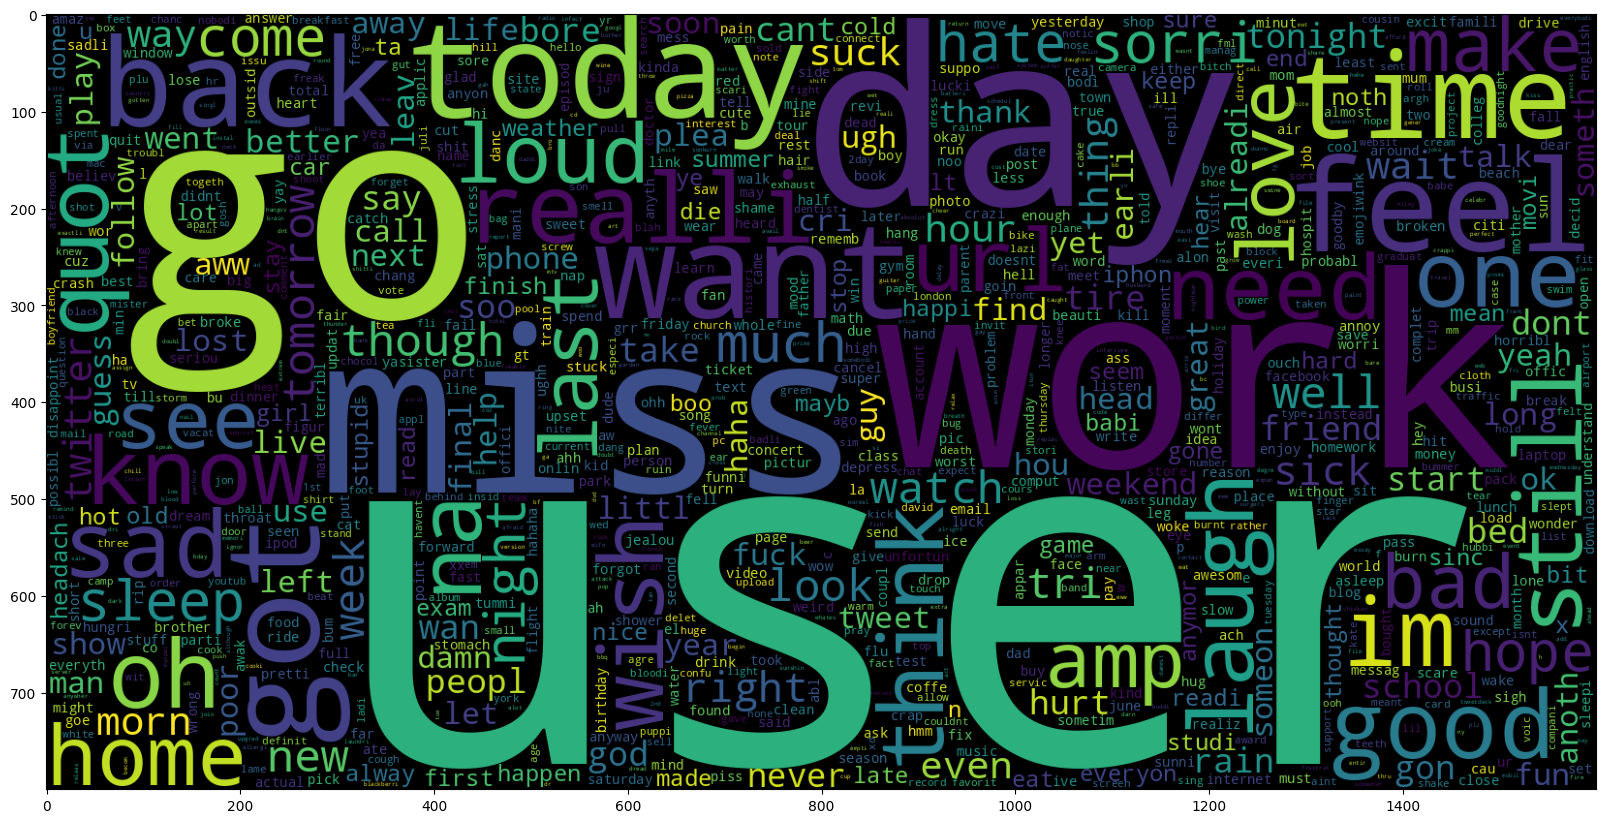

In [24]:
#The first 800000 tweets are negative, least are positive
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word cloud positive tweets

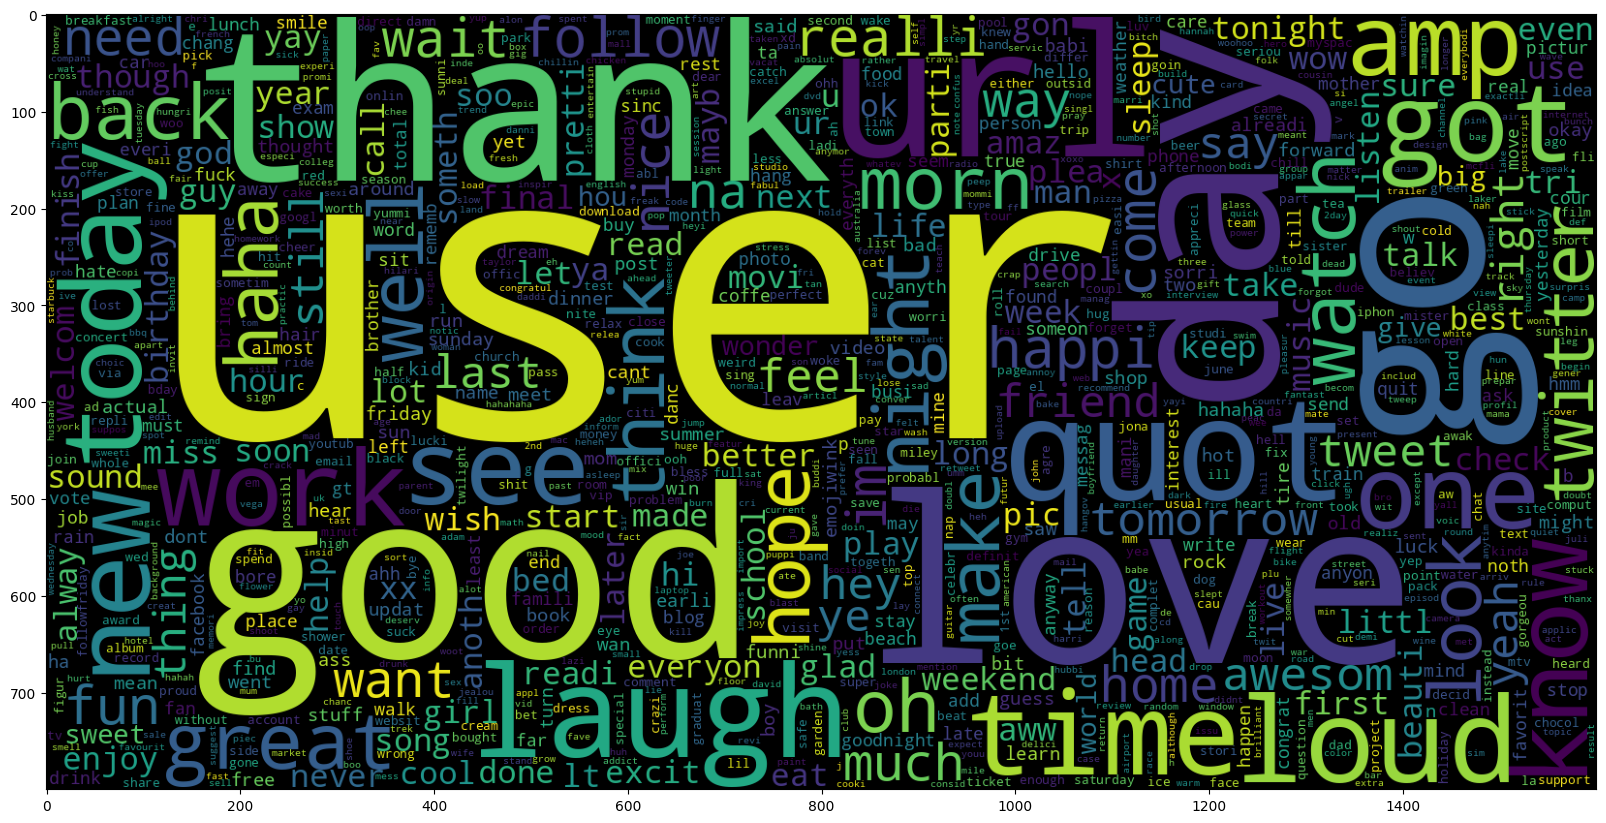

In [25]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [26]:
processedtext[:20]

['user url aww bummer shoulda got david carr third day emojiwink',
 'upset updat facebook text might cri result school today also blah',
 'user dive mani time ball manag save 50 rest go bound',
 'whole bodi feel itchi like fire',
 'user behav mad see',
 'user whole crew',
 'need hug',
 'user hey long time see ye rain bit bit laugh loud fine thank',
 'user nope',
 'user que muera',
 'spring break plain citi snow',
 'pierc ear',
 'user bear watch thought ua loss embarrass',
 'user count know either never talk anymor',
 'user would first gun realli though zac snyder doucheclown',
 'user wish got watch miss user premier',
 'holli death scene hurt sever watch film wri director cut',
 'file tax',
 'user ahh ive alway want see rent love soundtrack',
 'user oh dear drink forgotten tabl drink']

In [27]:
text[:20]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarrison i wo

Dataset split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 42)
print(f'Data Split done.')

Data Split done.


Transforming data in numeric values with TF-IDF Vectoriser

TF-IDF indicates what the importance of the word is in order to understand the document or dataset.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

ngram_range is the range of number of words in a sequence. [e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]

max_features specifies the number of features to consider. [Ordered by feature frequency across the corpus]

fitting the vectorizer on train data

In [29]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


Transforming the dataset

In [30]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


Model creation and evalution

In [31]:
def model_Evaluate(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [34]:
LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39999
           1       0.78      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.79     80000
weighted avg       0.80      0.80      0.79     80000



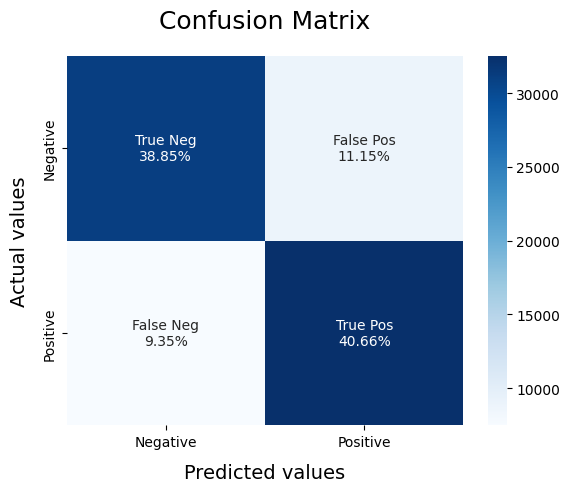

In [35]:
model_Evaluate(LRmodel)